In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_log_error, make_scorer

In [2]:
%matplotlib inline
sns.set()

In [3]:
import pickle
with open('../count-power-transformer.pkl', 'rb') as inf:
    pt = pickle.load(inf)
data = pd.read_pickle('../data-fill-windspeed.pkl.xz')
print(pt, pt.lambdas_)
data.head()

PowerTransformer(copy=True, method='box-cox', standardize=False) [0.31567024]


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,season_4,weather_1,weather_2,weather_3,weather_4,year,month,day,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,9.701265,3,...,0,1,0,0,0,2011,1,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,7.101665,8,...,0,1,0,0,0,2011,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,7.101665,5,...,0,1,0,0,0,2011,1,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,6.677052,3,...,0,1,0,0,0,2011,1,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,6.677052,0,...,0,1,0,0,0,2011,1,1,4,5


In [4]:
features = [
    'season_1', 'season_2', 'season_3', 'season_4',
    'weather_1', 'weather_2', 'weather_3', 'weather_4',
    'year', 'month', 'weekday', 'hour',
    'holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed',
]
target = 'count_transformed'

In [5]:
x = data[features]
y = data[target]
count_original = data['count']

In [6]:
x_train, x_testing, y_train, _, _, y_testing = train_test_split(
    x, y, count_original,
    test_size=0.25, random_state=42,
)
print(
    'training set:', x_train.shape, y_train.shape,
    '\n',
    'testing set:', x_testing.shape, y_testing.shape,
)

training set: (8164, 18) (8164,) 
 testing set: (2722, 18) (2722,)


## Train GBRT models

In [7]:
models=[GradientBoostingRegressor(), ]
model_names=['GradientBoostingRegressor', ]

In [8]:
for model in models:
    model.fit(x_train, y_train)

In [9]:
rmsle = []
predictions = []

for name, model in zip(model_names, models):
    y_pred = model.predict(x_testing)
    y_pred = pt.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    predictions.append(y_pred)
    rmsle.append(
        np.sqrt(
            mean_squared_log_error(
                y_pred,
                y_testing,
            )
        )
    )

result = pd.DataFrame({
    'Model': model_names,
    'RMSLE': rmsle,
})
result

,Model,RMSLE
0,GradientBoostingRegressor,0.421846


## Tunning models by grid search

### Define the scorer

1. define a function calculating RMSLE after inverse transforming data
2. make a scorer from function. `greater_is_better` is False in this case because we want the parameters leading to lowest RMSLE.

In [10]:
def root_mean_squared_log_error(y1, y2, transformer=pt):
    y2[y2<0] = 0
    y1 = y1.reshape(-1, 1)
    y2 = y2.reshape(-1, 1)
    if transformer:
        y1 = transformer.inverse_transform(y1)
        y2 = transformer.inverse_transform(y2)
    return np.sqrt(
        mean_squared_log_error(
            y1,
            y2,
        )
    )
rmsle_scorer = make_scorer(root_mean_squared_log_error, greater_is_better=False)

### Searching in grid then

In [11]:
gbrt_m = GradientBoostingRegressor()
gbrt_params = {
    'loss': ['ls', 'huber',],
    'alpha': [1e-2, 0.1, 0.5, 0.9, ],
    'n_estimators': [100, 400, ]
}
grid_gbrt = GridSearchCV(
    gbrt_m,
    gbrt_params,
    scoring=rmsle_scorer,
    cv=3
)
grid_gbrt.fit(x_train, y_train.to_numpy())

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter...
                             

### Check the results

In [12]:
grid_gbrt.best_estimator_

GradientBoostingRegressor(alpha=0.1, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=400,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [13]:
grid_gbrt.best_score_

-0.3148364031465193

### Visualize how RMSLE varies with different parameters

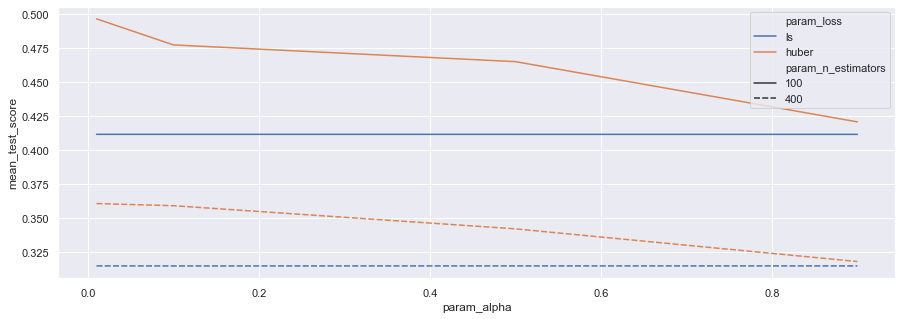

In [14]:
grid_results = pd.DataFrame(grid_gbrt.cv_results_).reindex(
    columns=['param_loss', 'param_n_estimators', 'param_alpha', 'mean_test_score']
)
grid_results['mean_test_score'] = np.abs(grid_results['mean_test_score'])
sns.lineplot(data=grid_results, x="param_alpha", y="mean_test_score", style='param_n_estimators', hue='param_loss')
plt.gcf().set_size_inches(15, 5)

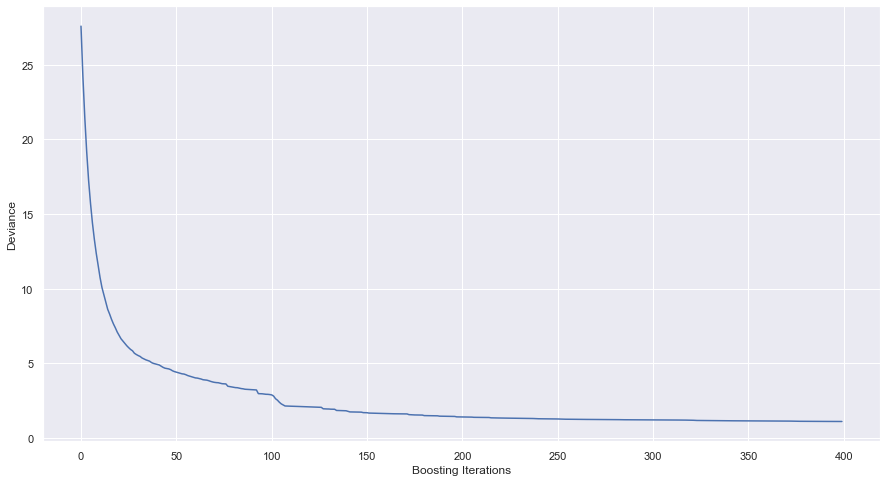

In [15]:
model = grid_gbrt.best_estimator_
sns.lineplot(data=model.train_score_)
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
plt.gcf().set_size_inches(15, 8)

In [16]:
y_pred = grid_gbrt.predict(x_testing)
y_pred = pt.inverse_transform(y_pred.reshape(-1, 1)).flatten()

result = pd.concat([
    result,
    pd.DataFrame(
        [
            [
                'Tuned GradientBoostingRegressor',
                np.sqrt(
                    mean_squared_log_error(
                        y_pred,
                        y_testing,
                    )
                ),
            ]
        ],
        columns=['Model', 'RMSLE', ])
], axis=0, sort=False)
result

,Model,RMSLE
0,GradientBoostingRegressor,0.421846
0,Tuned GradientBoostingRegressor,0.314822


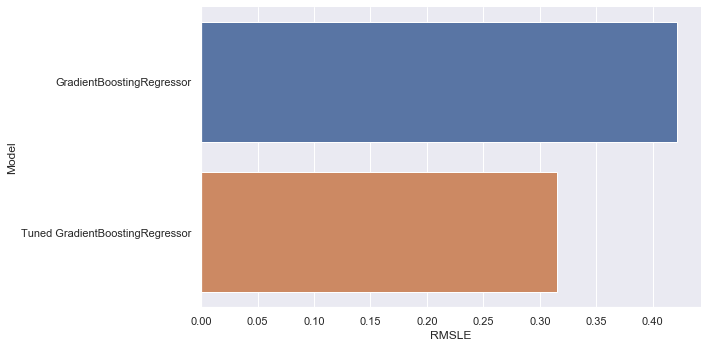

In [17]:
sns.catplot(
    x='RMSLE', y='Model',
    data=result,
    kind='bar', height=5, aspect=2
)
# plt.gca().set_xlim(1.01, 1.02)

,Model,RMSLE
0,RandomForestRegressor,0.310463
6,Tuned GradientBoostingRegressor,0.314822
2,BaggingRegressor,0.316238
5,GradientBoostingRegressor,0.421846
1,AdaBoostRegressor,0.631744
4,KNeighborsRegressor,0.740120
3,SVR,0.909996


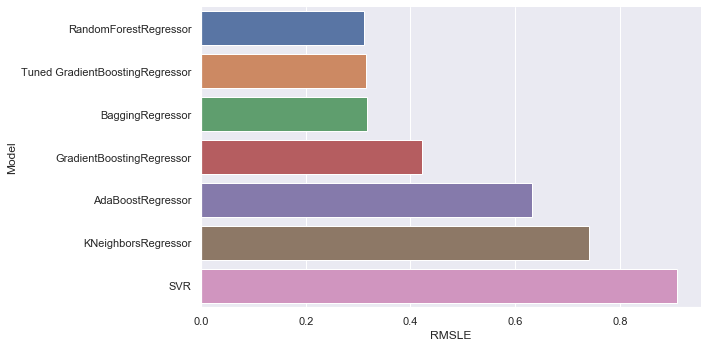

In [18]:
prev_result = pd.read_pickle('../rmsle_fill_windspeed.pkl')

all_result = pd.concat([
    prev_result, result
], axis=0, sort=True).reset_index().reindex(
    columns=['Model', 'RMSLE']
).sort_values(['RMSLE'])

sns.catplot(
    x='RMSLE', y='Model',
    data=all_result,
    kind='bar', height=5, aspect=2
)
all_result

In [19]:
all_result.to_pickle('../rmsle_gbrt.pkl')